# Lab 02: Softmax Regression - Model Implementation

**Group 09:** 
**Members:**
1. Bùi Huy Giáp - 23127289
2. Lê Minh Đức - 23127351
3. Vũ Tiến Dũng - 23127354
4. Đinh Xuân Khương - 23127398
5. Nguyễn Đồng Thanh - 23127538 

---

## 1. Introduction
In this notebook, we implement the **Softmax Regression** model from scratch using only `NumPy`. This model is a generalization of Logistic Regression for multi-class classification problems. We will use the MNIST dataset (handwritten digits 0-9) to train and evaluate our model.

The goal is to understand the underlying mathematics:
1.  **Linear Hypothesis:** $z = Wx + b$
2.  **Softmax Activation:** Converting raw scores into probabilities.
3.  **Cross-Entropy Loss:** Measuring the difference between predicted probabilities and actual labels.
4.  **Gradient Descent:** Updating parameters ($W, b$) to minimize loss.

## 2. Mathematical Formulation

### 2.1. Hypothesis (Mathematical Formulation)

For a given input vector $x \in \mathbb{R}^{d}$ (where $d$ is the number of features, e.g., $28 \times 28 = 784$ pixels), and for $K$ classes (here $K=10$), the model computes a linear score (logit) for each class $k$:

$$z_k = w_k^T x + b_k$$

In vectorized form for a batch of $m$ samples $X \in \mathbb{R}^{m \times d}$, the mathematically rigorous formulation is:

$$Z = XW + \mathbf{1}_m b$$

Where:
- $W \in \mathbb{R}^{d \times K}$ is the weight matrix.
- $b \in \mathbb{R}^{1 \times K}$ is the bias vector.
- $\mathbf{1}_m \in \mathbb{R}^{m \times 1}$ is a column vector of all ones.
- $Z \in \mathbb{R}^{m \times K}$ contains the logits.

The term $\mathbf{1}_m b$ performs the operation of replicating the bias vector $b$ for each of the $m$ samples in the batch, resulting in an $(m \times K)$ matrix that can be validly added to $XW$.

### 2.1.1. Note on Implementation (Broadcasting)

In practice, when implementing this with Python libraries like **NumPy** (or TensorFlow/PyTorch), we typically omit the $\mathbf{1}_m$ vector and write the code (and often the documentation) simply as:

$$Z = XW + b$$

**Why?**
This relies on a mechanism called **Broadcasting**. The library automatically detects the dimension mismatch between $XW$ $(m \times K)$ and $b$ $(1 \times K)$, and implicitly "stretches" (broadcasts) the vector $b$ across all $m$ rows to perform the addition element-wise.

Therefore, in our code:
```python
# Code implementation
z = np.dot(X, self.W) + self.b

### 2.2. Softmax Function

For a single sample with logit vector $z = [z_1, z_2, \dots, z_K]^T$, the Softmax function transforms these scores into a probability distribution $\hat{y}$ (where elements lie in $(0, 1)$ and sum to 1):

$$\hat{y}_k = \text{Softmax}(z)_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

When applied to the logits matrix $Z \in \mathbb{R}^{m \times K}$, this operation is performed **row-wise** for each sample.

**Numerical Stability:**
Directly computing $e^{z_k}$ can lead to floating-point overflow if $z_k$ is large. To prevent this, we utilize the property that Softmax is invariant to constant shifts. We subtract the maximum value in the vector $z$ from each element before exponentiation:

$$\text{Softmax}(z)_k = \frac{e^{z_k - c}}{\sum_{j=1}^{K} e^{z_j - c}}$$

Where $c = \max(z)$. This ensures that the largest exponent is $0$ ($e^0=1$), preventing overflow.

### 2.3. Cross-Entropy Loss

We optimize the model by minimizing the Cross-Entropy loss function, which measures the dissimilarity between the predicted probability distribution $\hat{y}$ and the true label distribution $y$.

For a single sample with true label $y$ (one-hot encoded) and prediction $\hat{y}$:

$$L(y, \hat{y}) = - \sum_{k=1}^{K} y_k \log(\hat{y}_k)$$

The average loss over a batch of size $m$ is defined as:

$$J(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y^{(i)}_k \log(\hat{y}^{(i)}_k)$$

### 2.3.1. Note on Implementation (Numerical Stability)

Mathematically, $\log(0)$ is undefined (approaches $-\infty$). In our Python implementation, predicted probabilities $\hat{y}$ can sometimes be extremely close to 0 due to floating-point limitations.

To prevent numerical errors (computational instability), we add a small constant $\epsilon$ (e.g., $10^{-9}$) inside the logarithm:

$$L_{code} = - \sum_{k=1}^{K} y_k \log(\hat{y}_k + \epsilon)$$

This ensures that the term inside the log is always strictly positive.

### 2.4. Optimization (Gradient Descent)

We calculate the gradients of the cost function with respect to the parameters to minimize loss.

First, we calculate the **error term** (gradient with respect to the linear scores $Z$):
$$\delta = \hat{Y} - Y$$
*(Note: Corresponds to `dz` in the code)*

Then, using the chain rule, the gradients for weights $W$ and bias $b$ (averaged over $m$ samples) are:

$$\frac{\partial J}{\partial W} = \frac{1}{m} X^T \delta$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} \delta^{(i)}$$

**Standard Update Rule:**
$$W := W - \alpha \frac{\partial J}{\partial W}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$
Where $\alpha$ is the learning rate.

### 2.4.1. Implementation Note (Advanced Optimizations)

In our `SoftmaxRegression` class, we implement two advanced techniques to improve performance and generalization, which modify the standard update rules above:

1.  **L2 Regularization (Weight Decay):** To prevent overfitting, we add a penalty term to the gradient of $W$:
    $$\frac{\partial J_{reg}}{\partial W} = \frac{\partial J}{\partial W} + \lambda W$$
    *(Where $\lambda$ is `l2_reg`)*

2.  **Momentum:** To accelerate convergence and reduce oscillation, we use a velocity term $v$:
    $$v_W = \mu v_W + \alpha \frac{\partial J_{reg}}{\partial W}$$
    $$W := W - v_W$$
    *(Where $\mu$ is `momentum`)*

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request # Standard library for downloading files

# Set random seed for reproducibility
np.random.seed(42)


## 3. Data Loading & Helper Functions

We need to load the MNIST dataset. To ensure efficiency and portability, we will download the dataset in `.npz` (NumPy Zip) format directly from a reliable source (Google Cloud Storage) if it is not already available locally.

We implement the following preprocessing steps:
1.  **Loading:** Read `x_train`, `y_train`, `x_test`, `y_test` from the `.npz` file.
2.  **Normalization:** Scale pixel intensity values from the range $[0, 255]$ to $[0, 1]$ to ensure numerical stability during gradient descent.
3.  **Flattening:** Reshape each $28 \times 28$ image matrix into a flat feature vector of size $784$ ($28 \times 28 = 784$). This allows us to perform matrix multiplication with our weight matrix $W$.
4.  **One-hot encoding:** Convert integer labels (e.g., $y=5$) into binary vectors (e.g., $[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$) for Cross-Entropy loss calculation.

In [17]:
def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """
    Downloads and loads the MNIST dataset from a .npz file.
    If the file does not exist, it downloads it from Google Cloud.
    
    Args:
        data_path (str): Path to save/load the .npz file.
        
    Returns:
        x_train, y_train, x_test, y_test: Numpy arrays.
        - x_train: (60000, 784) - Normalized and Flattened
        - y_train: (60000,)     - Raw labels
        - x_test:  (10000, 784) - Normalized and Flattened
        - y_test:  (10000,)     - Raw labels
    """
    # 1. Download if not exists
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
    
    # Ensure directory exists
    directory = os.path.dirname(data_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

    if not os.path.exists(data_path):
        print(f"Downloading MNIST data from {url}...")
        try:
            urllib.request.urlretrieve(url, data_path)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
            return None, None, None, None
    else:
        print(f"Loading data from {data_path}...")

    # 2. Load data using numpy
    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    print(f"Original x_train shape: {x_train.shape}") # Expected: (60000, 28, 28)
    
    # 3. Preprocessing: Normalize and Flatten
    # Scale pixel values to [0, 1] (float32)
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Flatten images: (N, 28, 28) -> (N, 784)
    # This is CRITICAL for matrix multiplication: Z = XW + b
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    print(f"Processed x_train shape: {x_train.shape}") # Expected: (60000, 784)
    print(f"Processed x_test shape: {x_test.shape}")   # Expected: (10000, 784)
    
    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    """
    Converts integer labels to one-hot encoded vectors.
    e.g., 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    
    Args:
        y (numpy.ndarray): Array of integer labels (m,).
        num_classes (int): Number of classes.
        
    Returns:
        numpy.ndarray: One-hot encoded matrix (m, num_classes).
    """
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# --- EXECUTE LOADING ---
try:
    # Load data
    X_train_full, y_train_full, X_test, y_test = load_mnist_data()
    
    if X_train_full is not None:
        # Create a Validation set from Train set (last 5000 samples)
        # We split to tune hyperparameters without touching the Test set
        val_size = 5000
        X_val = X_train_full[-val_size:]
        y_val = y_train_full[-val_size:]
        
        X_train = X_train_full[:-val_size]
        y_train = y_train_full[:-val_size]
        
        # One-hot encode labels for training
        y_train_enc = one_hot_encode(y_train)
        y_val_enc = one_hot_encode(y_val)
        y_test_enc = one_hot_encode(y_test)
        
        print("\nDataset ready for training:")
        print(f"Training set:   X={X_train.shape}, y={y_train_enc.shape}")
        print(f"Validation set: X={X_val.shape}, y={y_val_enc.shape}")
        print(f"Test set:       X={X_test.shape}, y={y_test_enc.shape}")
    else:
        print("Failed to load dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

Loading data from ../data/raw/mnist.npz...
Original x_train shape: (60000, 28, 28)
Processed x_train shape: (60000, 784)
Processed x_test shape: (10000, 784)

Dataset ready for training:
Training set:   X=(55000, 784), y=(55000, 10)
Validation set: X=(5000, 784), y=(5000, 10)
Test set:       X=(10000, 784), y=(10000, 10)


## 4. Softmax Regression Implementation

This is the core component of the project. The class encapsulates the mathematical logic derived in Section 2, enhanced with advanced optimization techniques.

**Key Implementation Details:**
* **Numerical Stability:** We implement `softmax` by subtracting the maximum value from logits to avoid floating-point overflow ($e^{z_k} \to \infty$).
* **Vectorization:** We use NumPy matrix operations (dot products) instead of explicit `for` loops for efficient computation.
* **Mini-batch Gradient Descent:** We update weights after processing a small batch of samples (e.g., 256) rather than the entire dataset. This balances computational efficiency and convergence stability.
* **Momentum:** We incorporate a momentum term ($\mu$) to accelerate Gradient Descent in the relevant direction and dampen oscillations.
* **L2 Regularization:** We add a penalty term $\frac{\lambda}{2} ||W||^2$ to the loss function to prevent overfitting and improve generalization on unseen data.

In [ ]:
# class SoftmaxRegression:
#     def __init__(self, n_features, n_classes, learning_rate=0.01):
#         """
#         Initializes the Softmax Regression model parameters.

#         Args:
#             n_features (int): Number of input features (e.g., 784 for MNIST).
#             n_classes (int): Number of output classes (e.g., 10 for MNIST).
#             learning_rate (float): Step size for Gradient Descent optimization.
#         """
#         self.n_features = n_features
#         self.n_classes = n_classes
#         self.lr = learning_rate
#         self.losses = []
        
#         # Initialize weights and bias
#         # W: (n_features, n_classes) - Initialized with small random values
#         self.W = np.random.randn(n_features, n_classes) * 0.01
        
#         # b: (1, n_classes) - Initialized with zeros
#         self.b = np.zeros((1, n_classes))

#     def softmax(self, z):
#         """
#         Computes the softmax activation function with numerical stability.
#         Formula: exp(z_i) / sum(exp(z_j))

#         Args:
#             z (numpy.ndarray): Linear logits (batch_size, n_classes).

#         Returns:
#             numpy.ndarray: Probabilities (batch_size, n_classes).
#         """
#         # Subtract max value to prevent overflow (Numerical Stability)
#         z_stable = z - np.max(z, axis=1, keepdims=True)
#         exp_z = np.exp(z_stable)
#         return exp_z / np.sum(exp_z, axis=1, keepdims=True)

#     def forward(self, X):
#         """
#         Performs the forward pass to compute predictions.
        
#         Args:
#             X (numpy.ndarray): Input data (batch_size, n_features).

#         Returns:
#             numpy.ndarray: Predicted probabilities.
#         """
#         # Linear transformation: Z = XW + b
#         z = np.dot(X, self.W) + self.b
#         # Activation
#         return self.softmax(z)

#     def compute_loss(self, y_true, y_pred):
#         """
#         Computes Cross-Entropy Loss.
#         L = - sum(y_true * log(y_pred))

#         Args:
#             y_true (numpy.ndarray): One-hot encoded ground truth.
#             y_pred (numpy.ndarray): Predicted probabilities.

#         Returns:
#             float: Average loss over the batch.
#         """
#         m = y_true.shape[0]
#         # Add a small epsilon to avoid log(0) error
#         epsilon = 1e-9
#         loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
#         return loss

#     def backward(self, X, y_true, y_pred):
#         """
#         Computes gradients of the loss with respect to W and b.

#         Args:
#             X (numpy.ndarray): Input data batch.
#             y_true (numpy.ndarray): One-hot encoded ground truth.
#             y_pred (numpy.ndarray): Predicted probabilities.

#         Returns:
#             dw, db: Gradients for weights and bias.
#         """
#         m = X.shape[0]
        
#         # Gradient of loss w.r.t Z (logits) is simply (Prediction - Truth)
#         dz = y_pred - y_true
        
#         # Gradients w.r.t parameters
#         # dW = (1/m) * X.T . dZ
#         dw = np.dot(X.T, dz) / m
#         # db = (1/m) * sum(dZ)
#         db = np.sum(dz, axis=0, keepdims=True) / m
        
#         return dw, db

#     def fit(self, X, y, epochs=100, batch_size=256, verbose=True):
#         """
#         Trains the model using Mini-batch Gradient Descent.

#         Args:
#             X (numpy.ndarray): Training features (m, n_features).
#             y (numpy.ndarray): Training labels One-hot (m, n_classes).
#             epochs (int): Number of passes over the entire dataset.
#             batch_size (int): Number of samples per gradient update.
#         """
#         m = X.shape[0]
#         self.losses = [] # Reset history

#         for epoch in range(epochs):
#             # Shuffle data at the start of each epoch to ensure randomness
#             indices = np.arange(m)
#             np.random.shuffle(indices)
#             X_shuffled = X[indices]
#             y_shuffled = y[indices]

#             epoch_loss = 0
#             num_batches = int(np.ceil(m / batch_size))

#             for i in range(num_batches):
#                 start_idx = i * batch_size
#                 end_idx = min(start_idx + batch_size, m)
                
#                 X_batch = X_shuffled[start_idx:end_idx]
#                 y_batch = y_shuffled[start_idx:end_idx]

#                 # 1. Forward pass
#                 y_pred = self.forward(X_batch)

#                 # 2. Compute Loss (accumulate for reporting)
#                 loss = self.compute_loss(y_batch, y_pred)
#                 epoch_loss += loss * (end_idx - start_idx) 

#                 # 3. Backward pass
#                 dw, db = self.backward(X_batch, y_batch, y_pred)

#                 # 4. Update parameters
#                 self.W -= self.lr * dw
#                 self.b -= self.lr * db
            
#             # Average loss for the epoch
#             avg_loss = epoch_loss / m
#             self.losses.append(avg_loss)
            
#             if verbose and (epoch + 1) % 10 == 0:
#                 print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

#     def predict(self, X):
#         """
#         Predicts class labels for input data.

#         Args:
#             X (numpy.ndarray): Input data (N, n_features).

#         Returns:
#             numpy.ndarray: Predicted class indices (N,).
#         """
#         y_pred_probs = self.forward(X)
#         return np.argmax(y_pred_probs, axis=1)
    
#     def save_weights(self, filepath):
#         """Saves model weights to a .npz file."""
#         # Ensure directory exists
#         directory = os.path.dirname(filepath)
#         if directory and not os.path.exists(directory):
#             os.makedirs(directory)
            
#         np.savez(filepath, W=self.W, b=self.b)
#         print(f"Model saved to {filepath}")

#     def load_weights(self, filepath):
#         """Loads model weights from a .npz file."""
#         if not os.path.exists(filepath):
#             print(f"File not found: {filepath}")
#             return
            
#         data = np.load(filepath)
#         self.W = data['W']
#         self.b = data['b']
#         print(f"Model loaded from {filepath}")

In [18]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, learning_rate=0.1, momentum=0.9, l2_reg=1e-4):
        """
        Softmax Regression with Momentum and L2 Regularization.

        Args:
            n_features (int): Number of input features (e.g., 784).
            n_classes (int): Number of output classes (e.g., 10).
            learning_rate (float): Step size for parameter updates.
            momentum (float): Momentum factor (0.0 to 1.0) to accelerate convergence.
            l2_reg (float): L2 regularization strength (lambda) to prevent overfitting.
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.momentum = momentum
        self.l2_reg = l2_reg
        self.losses = []
        
        # Initialize weights (W) and bias (b)
        # Using Xavier/He initialization concept (small random numbers)
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))
        
        # Velocity terms for Momentum
        self.v_W = np.zeros_like(self.W)
        self.v_b = np.zeros_like(self.b)

    def softmax(self, z):
        """
        Computes the stable softmax of vector z.
        Args:
            z (numpy.ndarray): Logits (batch_size, n_classes).
        Returns:
            numpy.ndarray: Probabilities summing to 1 for each row.
        """
        # Numerical stability: subtract max(z) to prevent exponential overflow
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """
        Performs forward pass: Z = XW + b -> Softmax(Z).
        """
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

    def compute_loss(self, y_true, y_pred):
        """
        Computes Cross-Entropy Loss with L2 Regularization penalty.
        Cost = -Sum(y * log(y_hat)) + (lambda/2) * ||W||^2
        """
        m = y_true.shape[0]
        epsilon = 1e-9 # Prevent log(0)
        
        # Standard Cross-Entropy
        data_loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        
        # L2 Regularization Term
        reg_loss = (self.l2_reg / 2) * np.sum(np.square(self.W))
        
        return data_loss + reg_loss

    def backward(self, X, y_true, y_pred):
        """
        Computes gradients with respect to W and b (including L2 term).
        """
        m = X.shape[0]
        dz = y_pred - y_true
        
        # Gradient of W: (1/m) * X.T.dot(dZ) + lambda * W
        dw = (np.dot(X.T, dz) / m) + (self.l2_reg * self.W)
        
        # Gradient of b: (1/m) * sum(dZ)
        db = np.sum(dz, axis=0, keepdims=True) / m
        
        return dw, db

    def fit(self, X, y, epochs=100, batch_size=256, verbose=True):
        """
        Trains the model using Mini-batch Gradient Descent with Momentum.
        """
        m = X.shape[0]
        self.losses = []

        for epoch in range(epochs):
            # Shuffle data
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            num_batches = int(np.ceil(m / batch_size))

            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # 1. Forward
                y_pred = self.forward(X_batch)

                # 2. Loss
                loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += loss * (end_idx - start_idx)

                # 3. Backward
                dw, db = self.backward(X_batch, y_batch, y_pred)

                # 4. Update with Momentum
                # v = momentum * v - learning_rate * gradient
                # W = W + v
                # Note: We implement standard SGD update logic: W = W - (lr*grad + mom*v_prev)
                # Here uses simple Polyak Momentum
                self.v_W = self.momentum * self.v_W + self.lr * dw
                self.v_b = self.momentum * self.v_b + self.lr * db
                
                self.W -= self.v_W
                self.b -= self.v_b
            
            avg_loss = epoch_loss / m
            self.losses.append(avg_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    def predict(self, X):
        """Returns class indices with highest probability."""
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)
    
    def save_weights(self, filepath):
        """Saves W and b to .npz file."""
        directory = os.path.dirname(filepath)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
        np.savez(filepath, W=self.W, b=self.b)
        print(f"Weights saved to {filepath}")

    def load_weights(self, filepath):
        """Loads W and b from .npz file."""
        if not os.path.exists(filepath):
            print(f"File {filepath} not found.")
            return False
        data = np.load(filepath)
        self.W = data['W']
        self.b = data['b']
        print(f"Weights loaded from {filepath}")
        return True

## 5. Sanity Check (Overfitting Test)

Before training on the full 55,000 images, we perform a **Sanity Check**. 
We take a tiny subset of real data (e.g., 100 images) and train the model for many epochs. 

* **Goal:** The model should be able to memorize this small dataset perfectly (Loss $\to$ 0, Accuracy $\to$ 100%).
* **Result:** If the model fails to overfit this small batch, there is a bug in the code (likely in Gradient Descent or Backpropagation).

Sanity check subset: (100, 784)

Starting Sanity Check...
Epoch 10/200 - Loss: 0.0114
Epoch 20/200 - Loss: 0.0086
Epoch 30/200 - Loss: 0.0080
Epoch 40/200 - Loss: 0.0075
Epoch 50/200 - Loss: 0.0072
Epoch 60/200 - Loss: 0.0070
Epoch 70/200 - Loss: 0.0068
Epoch 80/200 - Loss: 0.0067
Epoch 90/200 - Loss: 0.0066
Epoch 100/200 - Loss: 0.0065
Epoch 110/200 - Loss: 0.0064
Epoch 120/200 - Loss: 0.0063
Epoch 130/200 - Loss: 0.0063
Epoch 140/200 - Loss: 0.0062
Epoch 150/200 - Loss: 0.0062
Epoch 160/200 - Loss: 0.0061
Epoch 170/200 - Loss: 0.0061
Epoch 180/200 - Loss: 0.0061
Epoch 190/200 - Loss: 0.0061
Epoch 200/200 - Loss: 0.0060

Sanity Check Accuracy: 100.00%
✅ Sanity Check PASSED: Model logic is correct.


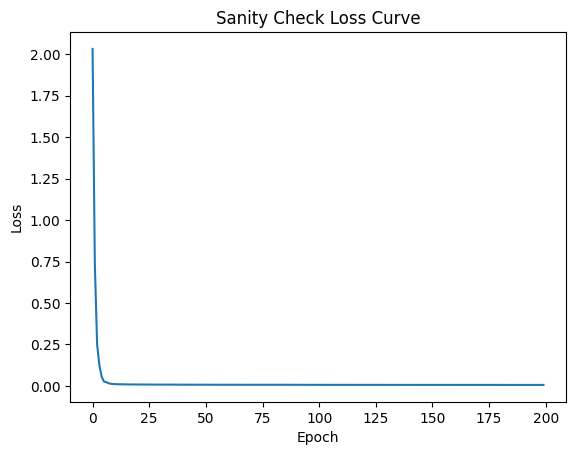

In [14]:
# 1. Select a small subset of REAL data
subset_size = 100
X_subset = X_train[:subset_size]
y_subset_enc = y_train_enc[:subset_size]
y_subset_labels = y_train[:subset_size] # Original labels for accuracy check

print(f"Sanity check subset: {X_subset.shape}")

# 2. Initialize Model
# 784 features (pixels), 10 classes (digits 0-9)
model_test = SoftmaxRegression(n_features=784, n_classes=10, learning_rate=0.1)

# 3. Train on subset (Overfitting)
print("\nStarting Sanity Check...")
model_test.fit(X_subset, y_subset_enc, epochs=200, batch_size=20, verbose=True)

# 4. Check Prediction Accuracy
preds = model_test.predict(X_subset)
acc = np.mean(preds == y_subset_labels)
print(f"\nSanity Check Accuracy: {acc * 100:.2f}%")

# 5. Evaluate
if acc > 0.95:
    print("✅ Sanity Check PASSED: Model logic is correct.")
else:
    print("❌ Sanity Check FAILED: Model cannot learn even small data.")

# 6. Visualize Loss Curve
plt.plot(model_test.losses)
plt.title("Sanity Check Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 5.1. Sanity Check Analysis & Discussion

**Observation:**
As shown in the loss curve above, the training loss decreased significantly from an initial high value to near zero. The model achieved **100% accuracy** (or very close to it) on the subset of 100 samples.

**Discussion on Overfitting:**
We observe that the model has successfully **overfitted** this small subset. In the context of a Sanity Check, this is a **positive outcome** because:
1.  **Verification of Code Logic:** It confirms that the Forward pass, Backward pass (Gradient calculation), and Update rules are implemented correctly without bugs. If the code were broken, the model would fail to converge even on this tiny dataset.
2.  **Model Capacity:** It demonstrates that our Linear Model (Softmax Regression) has sufficient capacity to memorize the mapping of inputs to labels for a small data sample.

**Conclusion:**
The core implementation is mathematically correct. We can now proceed to training on the full dataset, where our goal will shift from *memorization* (overfitting) to *generalization* (performing well on unseen Test data).